In [1]:
# local
import os
ROOT = os.path.abspath('')

In [2]:
import torch, os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Chargement Data:

In [4]:
train_df = pd.read_csv(os.path.join(ROOT, 'BUILD/train.csv'))
valid_df = pd.read_csv(os.path.join(ROOT, 'BUILD/dev.csv'))
test_df = pd.read_csv(os.path.join(ROOT, 'BUILD/test.csv'))

In [5]:
#train_df.head(5)

Mapage des labels:

In [6]:
rr_labels = [
    'PREAMBLE',
    'FAC',
    'RLC',
    'ISSUE',
    'ARG_PETITIONER',
    'ARG_RESPONDENT',
    'ANALYSIS',
    'STA',
    'PRE_RELIED',
    'PRE_NOT_RELIED',
    'RATIO',
    'RPC',
    'NONE'
]
MAP_LABEL = {k: i for i, k in enumerate(rr_labels)}
print(MAP_LABEL)

{'PREAMBLE': 0, 'FAC': 1, 'RLC': 2, 'ISSUE': 3, 'ARG_PETITIONER': 4, 'ARG_RESPONDENT': 5, 'ANALYSIS': 6, 'STA': 7, 'PRE_RELIED': 8, 'PRE_NOT_RELIED': 9, 'RATIO': 10, 'RPC': 11, 'NONE': 12}


In [7]:
train_df["labels_class"] = train_df['labels'].apply(lambda x: MAP_LABEL[x])
valid_df["labels_class"] = valid_df['labels'].apply(lambda x: MAP_LABEL[x])


Distribution des classes:

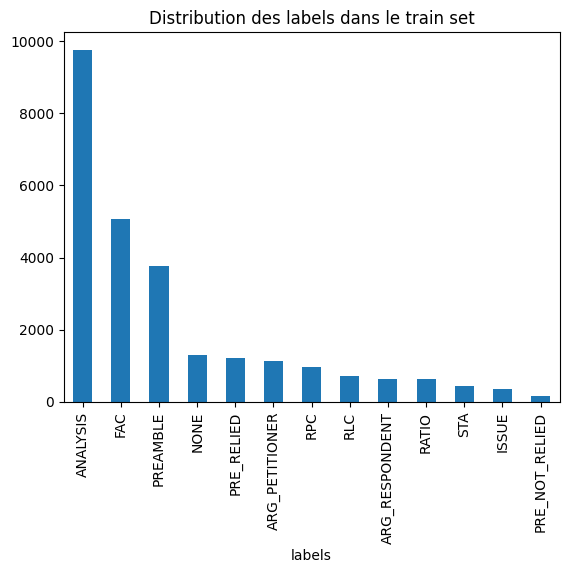

In [8]:
train_df["labels"].value_counts().plot(kind='bar')
plt.title('Distribution des labels dans le train set')
plt.show()

In [34]:
#compter la distribution des labels dans le test set
train_df["labels"].value_counts()

labels
ANALYSIS          9765
FAC               5070
PREAMBLE          3778
NONE              1286
PRE_RELIED        1221
ARG_PETITIONER    1120
RPC                954
RLC                711
ARG_RESPONDENT     620
RATIO              619
STA                443
ISSUE              344
PRE_NOT_RELIED     156
Name: count, dtype: int64

Création d'un dataset équilibré:

In [41]:
from sklearn.utils import resample

# Identifiez la classe minoritaire
minority_class = train_df["labels"].value_counts().idxmin()

# Créez des sous-ensembles par classe
subsets_by_class = {}
for label, group in train_df.groupby("labels"):
    subsets_by_class[label] = group

# Échantillonnez de manière équilibrée
sampled_subsets = []
desired_sample_size = min(train_df["labels"].value_counts())
for label, subset in subsets_by_class.items():
    if label == minority_class:
        sampled_subset = subset
    else:
        sampled_subset = resample(subset, replace=True, n_samples=desired_sample_size, random_state=42)
    sampled_subsets.append(sampled_subset)

# Combinez les sous-ensembles équilibrés
balanced_train_df = pd.concat(sampled_subsets)

# Vérifiez la distribution des classes
print(balanced_train_df["labels"].value_counts())


labels
ANALYSIS          156
ARG_PETITIONER    156
ARG_RESPONDENT    156
FAC               156
ISSUE             156
NONE              156
PREAMBLE          156
PRE_NOT_RELIED    156
PRE_RELIED        156
RATIO             156
RLC               156
RPC               156
STA               156
Name: count, dtype: int64


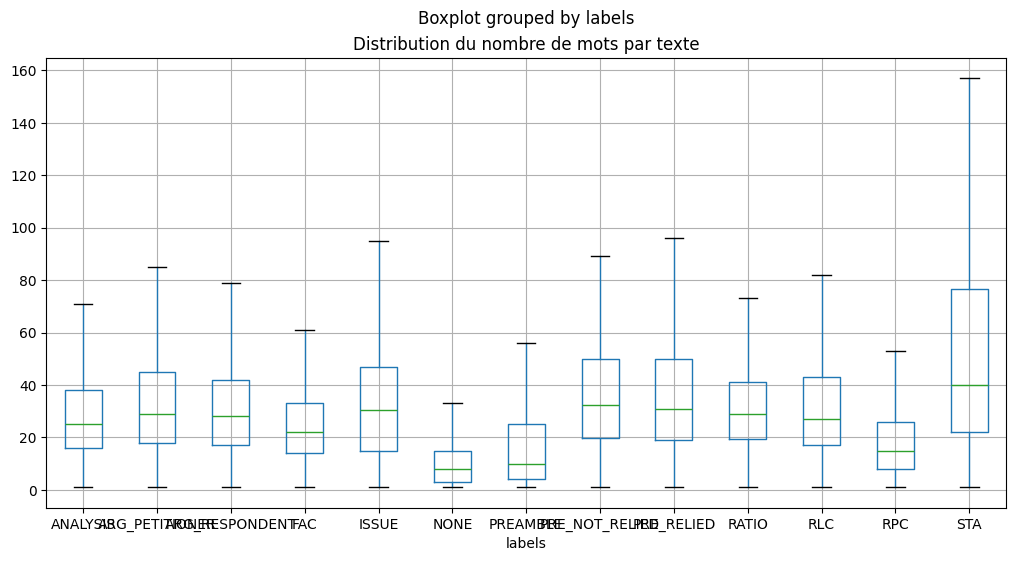

In [9]:
#estimation de la longueur des textes
train_df['mots_par_texte'] = train_df['text'].apply(lambda x: len(x.split()))
train_df.boxplot(column='mots_par_texte', by='labels', figsize=(12, 6), showfliers=False)
plt.title('Distribution du nombre de mots par texte')
plt.show()

## Transformers

In [10]:
# Charger le modèle

def load_model(path, device, **kwargs):
    model = AutoModelForSequenceClassification.from_pretrained(path, **kwargs)
    model = model.to(device)
    return model

def load_tokenizer(path):
    tokenizer = AutoTokenizer.from_pretrained(path)
    return tokenizer

In [11]:
class BUILDDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, device):
        self.ids = df.index.tolist() # récupérer les ids
        self.encodings = tokenizer( # encodage des textes
            df['text'].tolist(),
            truncation=True, 
            padding=True, 
            max_length=512,
            return_tensors='pt'
        )
        self.labels = df['labels_class'].tolist() # récupérer les labels
        self.device = device

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Tokenization:

In [12]:
tokenizer = load_tokenizer('distilbert-base-uncased')
model = load_model('distilbert-base-uncased', device, num_labels=len(rr_labels))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
#train_dataset = BUILDDataset(train_df, tokenizer, device)
valid_dataset = BUILDDataset(valid_df, tokenizer, device)

In [43]:
balanced_train_dataset = BUILDDataset(balanced_train_df, tokenizer, device)

In [14]:
#train_dataset.__getitem__(0)

Configuration du modèle:

In [1]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,             # total number of training epochs
    max_steps=100,                    # trains for 10 batches
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch', # evaluer à chaque epoch
    save_strategy='epoch', # sauvegarder à chaque epoch
    report_to="tensorboard",  # Ajoutez cette ligne pour utiliser TensorBoard
)

trainer = Trainer(
    model=model.to(device),                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=balanced_train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
)

NameError: name 'TrainingArguments' is not defined

In [ ]:
trainer.train()

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [21]:
# Faites les prédictions sur les données de validation
predictions = trainer.predict(valid_dataset)

  0%|          | 0/91 [00:00<?, ?it/s]

In [22]:
# Obtenez les étiquettes prédites et les vraies étiquettes
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = valid_dataset.labels


In [23]:
# Calculez les scores de précision, de rappel et de f-mesure
report = classification_report(true_labels, predicted_labels, target_names=rr_labels, output_dict=True)

c:\Users\hugol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hugol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hugol\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [38]:
# Afficher le rapport dans un DataFrame
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
PREAMBLE,0.642715,0.827763,0.723596,389.000000
FAC,0.584475,0.189911,0.286674,674.000000
RLC,0.000000,0.000000,0.000000,41.000000
ISSUE,0.000000,0.000000,0.000000,23.000000
ARG_PETITIONER,0.000000,0.000000,0.000000,195.000000
ARG_RESPONDENT,0.000000,0.000000,0.000000,78.000000
ANALYSIS,0.402937,0.944086,0.564812,930.000000
STA,0.000000,0.000000,0.000000,38.000000
PRE_RELIED,0.000000,0.000000,0.000000,210.000000
PRE_NOT_RELIED,0.000000,0.000000,0.000000,2.000000


Matrice de confusion:

In [26]:
# Calculez la matrice de confusion
confusion = confusion_matrix(true_labels, predicted_labels)

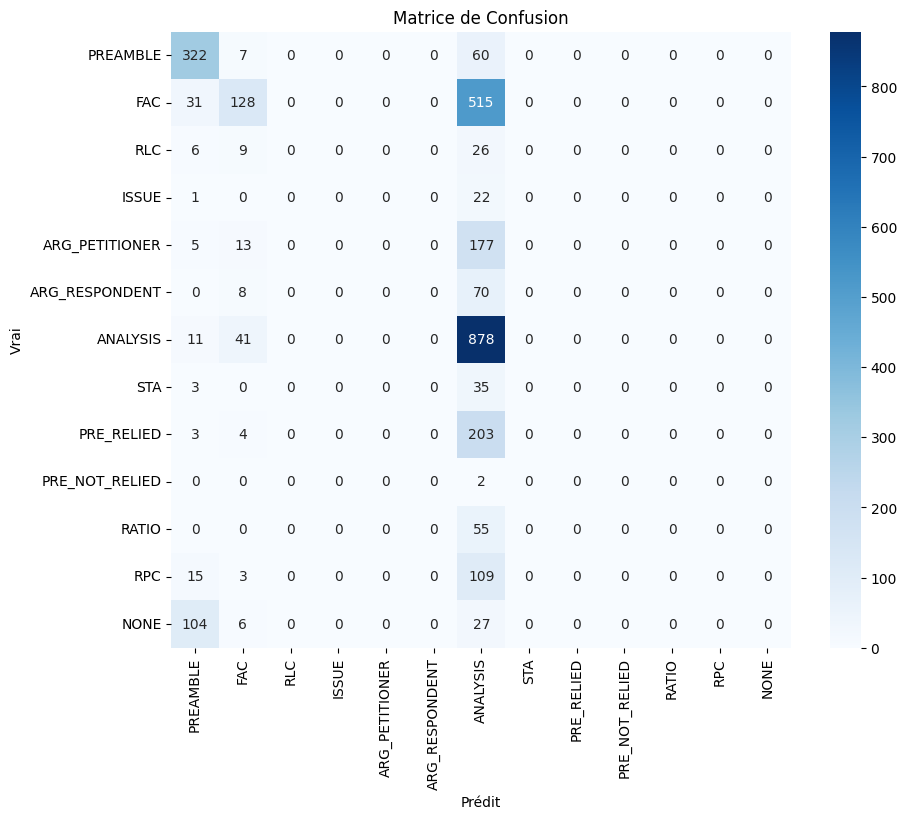

In [27]:
# Affichez la matrice de confusion sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=rr_labels, yticklabels=rr_labels)
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.title('Matrice de Confusion')
plt.show()

In [31]:
#afficher dans un dataframe pandas la matrice de confusion
df_confusion = pd.DataFrame(confusion, index=rr_labels, columns=rr_labels)